# Classification Models


In this notebook we will be building classification models on preprocessed data.

In [1]:
import os
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import warnings

from CogniPredictAD.classification import ADNIClassifier
from CogniPredictAD.visualization import Visualizer
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import export_text, export_graphviz, plot_tree, _tree

pd.set_option("display.max_rows", 116)
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_info_columns", 40) 

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    message=".*The `disp` and `iprint` options of the L-BFGS-B solver are deprecated.*",
    category=DeprecationWarning
)

train = pd.read_csv("../data/train.csv")

display(train)

,DX,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,CDRSB,ADAS13,LDELTOTAL,FAQ,MOCA,TRABSCOR,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,mPACCdigit,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,FDG,PTAU/ABETA,Hippocampus/ICV,Entorhinal/ICV,Fusiform/ICV,MidTemp/ICV,Ventricles/ICV,WholeBrain/ICV
0,2,77,0,16,1,28,2.5,5,1,0,24,108,47,5,63.63640,-4.84005,2.250,2.111110,1.000000,1.00,1.333330,1.00,2.375000,2.111110,2.428570,2.60,2.833330,2.75000,1.222830,0.040838,0.004524,0.001882,0.012107,0.011311,0.016977,0.706210
1,0,59,1,16,1,30,0.0,0,19,0,30,47,71,2,0.00000,5.42702,1.000,1.000000,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.00,1.000000,1.00000,1.161970,0.020445,0.004452,0.002756,0.012935,0.014299,0.025614,0.752850
2,3,77,1,12,2,22,8.0,30,0,25,17,300,19,1,100.00000,-18.90540,2.300,1.844446,1.248572,1.58,1.366668,1.75,3.841666,2.847620,3.033334,2.97,3.166668,3.80000,0.924559,0.047131,0.002825,0.001348,0.010049,0.009701,0.053417,0.522572
3,2,82,1,20,0,26,1.5,21,4,0,24,63,35,1,85.71430,-7.95749,1.850,1.269446,1.166668,1.20,1.466668,1.60,1.941666,1.294444,1.100002,1.16,1.733332,2.10000,1.119130,0.020198,0.003736,0.002083,0.013038,0.013942,0.024176,0.637729
4,0,83,0,17,0,27,0.0,5,13,3,25,98,57,7,7.14286,-1.94841,1.250,1.333330,1.000000,1.00,1.333330,1.00,1.375000,1.111110,1.666670,1.00,1.833330,1.25000,1.279034,0.026879,0.004611,0.002170,0.011387,0.012975,0.052196,0.635279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,0,72,0,18,1,30,0.0,4,11,0,26,52,42,7,18.18180,2.22837,1.500,2.333330,1.285710,1.00,2.500000,1.25,1.250000,1.000000,1.200000,1.00,1.333330,1.50000,1.416100,0.013555,0.005079,0.003304,0.014043,0.013729,0.027992,0.710296
1930,3,72,0,12,1,26,7.0,29,5,18,19,67,34,-1,100.00000,-9.28099,1.500,1.000000,1.142860,1.00,1.000000,1.00,3.250000,2.333330,2.428570,3.20,3.000000,3.50000,1.268520,0.080942,0.004383,0.001691,0.011582,0.011346,0.022499,0.711762
1931,0,70,0,17,0,29,0.0,23,10,0,20,300,31,4,42.85710,-2.30539,1.125,1.111110,1.000000,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.00,1.000000,1.00000,1.456170,0.007661,0.005042,0.002406,0.013522,0.013008,0.013065,0.711396
1932,0,84,1,12,0,30,0.5,16,13,0,26,65,27,1,80.00000,-1.42719,2.000,2.000000,2.000000,2.00,1.500000,2.00,1.625000,1.222220,1.285710,1.25,1.000000,1.66667,1.318880,0.021033,0.004567,0.002176,0.012360,0.013614,0.026801,0.663416


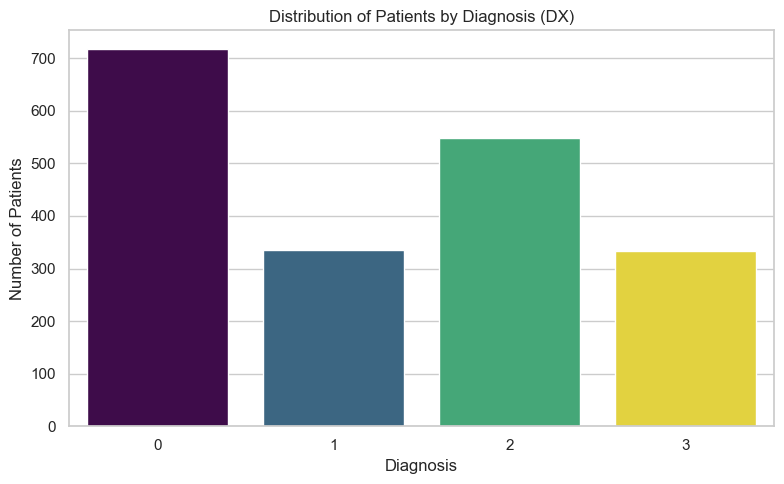

In [2]:
viz = Visualizer(train)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = [0, 1, 2, 3],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX)"
)

We already see that: 
- CN:   717 -> 37.07%
- EMCI: 336 -> 17.37%
- LMCI: 548 -> 28.34%
- AD:   333 -> 17.22%

In [3]:
# Target column
y_train = train['DX']

# All other columns as features
X_train = train.drop(columns=['DX'])

The **ADNIClassifier** class was designed as a support tool for training and evaluating different classification models on data derived from the ADNI dataset. Upon initialization, it allows you to choose between different sets of classifiers, which can be traditional models or explainable methods (XAI), already configured with the best hyperparameters found via grid search. The main function, `fit_evaluate_store_models`, takes the training data and, for each classifier, performs a repeated stratified cross-validation (5-fold by default), collects predictions and probabilities, calculates global and class-specific metrics, generates comparison plots and confusion matrices. Finally, it refits each model on the entire training set, saves it to disk, and returns two DataFrames: one with the overall metrics and one with the results by class.

## Explainability Function for Decision Tree

In [4]:
def save_xai_models(X_train, y_train, models_dir="../results/all_models"):
    """
    Load models from models_dir and save XAI outputs (rules and tree images)
    only for models whose filenames start with "Decision_Tree".
    """
    # Base directories for saving rules and trees
    trees_base = os.path.join(models_dir, "trees")
    rules_base = os.path.join(models_dir, "rules")
    for d in (trees_base, rules_base):
        os.makedirs(d, exist_ok=True)

    outputs = {}

    # Get feature names (if DataFrame -> column names, else generic f0, f1, ...)
    if hasattr(X_train, "columns"):
        feature_names = list(X_train.columns)
    else:
        feature_names = [f"f{i}" for i in range(X_train.shape[1])]

    # Ensure models_dir exists
    if not os.path.isdir(models_dir):
        raise FileNotFoundError(f"models_dir not found: {models_dir}")

    # Load models whose filename starts with "Decision_Tree"
    models = []
    for fname in os.listdir(models_dir):
        if fname.endswith(".pkl") and fname.startswith("Decision_Tree"):
            model_path = os.path.join(models_dir, fname)
            try:
                with open(model_path, "rb") as f:
                    model = pickle.load(f)
                model_name = os.path.splitext(fname)[0]
                models.append((model_name, model))
            except Exception as e:
                print(f"Could not load {fname}: {e}")

    print(f"Found {len(models)} Decision_Tree models:", [n for n, _ in models])

    # Process filtered models
    for model_name, model in models:
        print(f"Processing {model_name}")
        outputs[model_name] = {"rules": None, "tree_image": None, "notes": []}

        is_tree = hasattr(model, "tree_")
        if not is_tree:
            outputs[model_name]["notes"].append("Not recognized as DecisionTree-like model.")
            continue

        # Export textual rules
        try:
            rules_text = export_text(model, feature_names=feature_names)
            rules_text_ifthen = []
            for line in rules_text.splitlines():
                stripped = line.lstrip()
                indent = (len(line) - len(stripped)) // 4
                if stripped.startswith("|---"):
                    condition = stripped.replace("|---", "").strip()
                    rules_text_ifthen.append("    " * indent + "IF " + condition)
                else:
                    rules_text_ifthen.append("    " * indent + stripped.replace("class:", "THEN class ="))
            rules_text = "\n".join(rules_text_ifthen)

            rules_path = os.path.join(rules_base, f"{model_name}_rules.txt")
            with open(rules_path, "w", encoding="utf-8") as f:
                f.write(rules_text)
            outputs[model_name]["rules"] = rules_path
        except Exception as e:
            outputs[model_name]["notes"].append(f"Failed to export rules: {e}")

        # Export tree diagram
        try:
            class_names = [str(c) for c in getattr(model, "classes_", [])]

            dot_data = export_graphviz(
                model, out_file=None,
                feature_names=feature_names,
                class_names=class_names,
                filled=True, rounded=True, special_characters=True
            )

            outbase = os.path.join(trees_base, f"{model_name}_tree")
            graph = graphviz.Source(dot_data)
            graph.graph_attr.update({'nodesep': '0.4', 'ranksep': '0.5', 'margin': '0.5', 'dpi': '600'})
            graph.node_attr.update({'fontsize': '10', 'shape': 'box', 'margin': '0.5'})
            graph.edge_attr.update({'fontsize': '12'})

            rendered_path = graph.render(outbase, format="pdf", cleanup=True)
            outputs[model_name]["tree_image"] = rendered_path
        except Exception as e_graphviz:
            outputs[model_name]["notes"].append(f"Graphviz rendering failed: {e_graphviz}. Using matplotlib fallback.")
            try:
                fig, ax = plt.subplots(figsize=(16, 12))
                plot_tree(model, feature_names=feature_names, filled=True, rounded=True, ax=ax)
                out_pdf = os.path.join(trees_base, f"{model_name}_tree.pdf")
                fig.savefig(out_pdf, bbox_inches="tight", dpi=600)
                plt.close(fig)
                outputs[model_name]["tree_image"] = out_pdf
            except Exception as e2:
                outputs[model_name]["notes"].append(f"Matplotlib fallback failed: {e2}")

    print("XAI outputs saved.")

## Build Dataset with Hybrid Sampling

In [5]:
print("Original class distribution (count):")
print(y_train.value_counts())
print("\nOriginal class distribution (percentages):")
print((y_train.value_counts(normalize=True) * 100).round(2))

Original class distribution (count):
DX
0    717
2    548
1    336
3    333
Name: count, dtype: int64

Original class distribution (percentages):
DX
0    37.07
2    28.34
1    17.37
3    17.22
Name: proportion, dtype: float64


In [6]:
# Oversampling strategy: only for classes smaller than target_count
oversample_dict = {1: 500, 3: 500}

# Undersampling strategy: only for classes larger than target_count
undersample_dict = {0: 500, 2: 500}

categorical_features = [
    X_train.columns.get_loc("PTGENDER"),
    X_train.columns.get_loc("APOE4")
]

print("\nOversample dict (SMOTENC) -> classes to increase:")
print(oversample_dict)
print("\nUndersample dict (RUS) -> classes to reduce:")
print(undersample_dict)


Oversample dict (SMOTENC) -> classes to increase:
{1: 500, 3: 500}

Undersample dict (RUS) -> classes to reduce:
{0: 500, 2: 500}


In [7]:
steps = []
if oversample_dict:
    smotenc = SMOTENC(
        categorical_features=categorical_features,
        sampling_strategy=oversample_dict,
        random_state=42
    )
    steps.append(('smotenc', smotenc))

if undersample_dict:
    rus = RandomUnderSampler(
        sampling_strategy=undersample_dict,
        random_state=42
    )
    steps.append(('rus', rus))

if not steps:
    print("No resampling needed (all classes already balanced).")
    X_res, y_res = X_train.copy(), y_train.copy()
else:
    pipeline = Pipeline(steps=steps)
    X_res, y_res = pipeline.fit_resample(X_train, y_train)

# Distribution after resampling
print("\nClass distribution after resampling (count):")
print(pd.Series(y_res).value_counts().sort_index())
print("\nClass distribution after resampling (percentages):")
print((pd.Series(y_res).value_counts(normalize=True) * 100).round(2))
X_res.describe().T


Class distribution after resampling (count):
DX
0    500
1    500
2    500
3    500
Name: count, dtype: int64

Class distribution after resampling (percentages):
DX
0    25.0
1    25.0
2    25.0
3    25.0
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
AGE,2000.0,72.623000,7.311813,52.000000,68.000000,73.000000,78.000000,90.000000
PTGENDER,2000.0,0.550500,0.497568,0.000000,0.000000,1.000000,1.000000,1.000000
PTEDUCAT,2000.0,15.890500,2.707060,4.000000,14.000000,16.000000,18.000000,20.000000
APOE4,2000.0,0.585000,0.662567,0.000000,0.000000,0.000000,1.000000,2.000000
MMSE,2000.0,26.884000,2.857206,16.000000,25.000000,28.000000,29.000000,30.000000
CDRSB,2000.0,1.835129,1.864356,0.000000,0.500000,1.495481,3.000000,10.000000
ADAS13,2000.0,17.359500,9.926254,0.000000,10.000000,15.000000,24.000000,56.000000
LDELTOTAL,2000.0,6.852500,5.229954,0.000000,2.000000,7.000000,10.000000,22.000000
FAQ,2000.0,4.719000,6.473947,0.000000,0.000000,1.000000,8.000000,30.000000
MOCA,2000.0,22.157000,4.365992,4.000000,20.000000,23.000000,25.000000,30.000000


## Dataset with `CDRSB`, `LDELTOTAL`, and `mPACCdigit` with Classification

In [8]:
classifier = ADNIClassifier(classifier="Standard1")

### No Sampling

Training & Evaluating: Decision Tree
Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: CatBoost
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: Bagging


,Model,Accuracy,Balanced Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),F1 Score (macro),ROC AUC (macro)
3,XGBoost,0.932092,0.921863,0.932176,0.932092,0.931935,0.921589,0.988434
5,CatBoost,0.928818,0.918172,0.929135,0.928818,0.928688,0.918458,0.987165
2,Extra Trees,0.928818,0.919840,0.929312,0.928818,0.928880,0.918871,0.987122
4,LightGBM,0.931748,0.921442,0.932291,0.931748,0.931478,0.921114,0.985813
1,Random Forest,0.928301,0.917331,0.928337,0.928301,0.928041,0.916865,0.984900
7,Bagging,0.928645,0.918030,0.928776,0.928645,0.928497,0.917857,0.981729
6,Multinomial Logistic Regression,0.887797,0.881650,0.891202,0.887797,0.888457,0.873890,0.979621
0,Decision Tree,0.906412,0.902138,0.909387,0.906412,0.907029,0.894368,0.973315


,Model,Class,Precision,Recall,F1 Score,Support
0,Decision Tree,0,0.981792,0.952580,0.966966,2151.0
1,Decision Tree,1,0.874545,0.954365,0.912713,1008.0
2,Decision Tree,2,0.908913,0.849757,0.878340,1644.0
3,Decision Tree,3,0.789425,0.851852,0.819451,999.0
4,Random Forest,0,0.982605,0.971641,0.977092,2151.0
5,Random Forest,1,0.907547,0.954365,0.930368,1008.0
6,Random Forest,2,0.900955,0.918491,0.909639,1644.0
7,Random Forest,3,0.877529,0.824825,0.850361,999.0
8,Extra Trees,0,0.982922,0.963273,0.972998,2151.0
9,Extra Trees,1,0.902765,0.939484,0.920758,1008.0


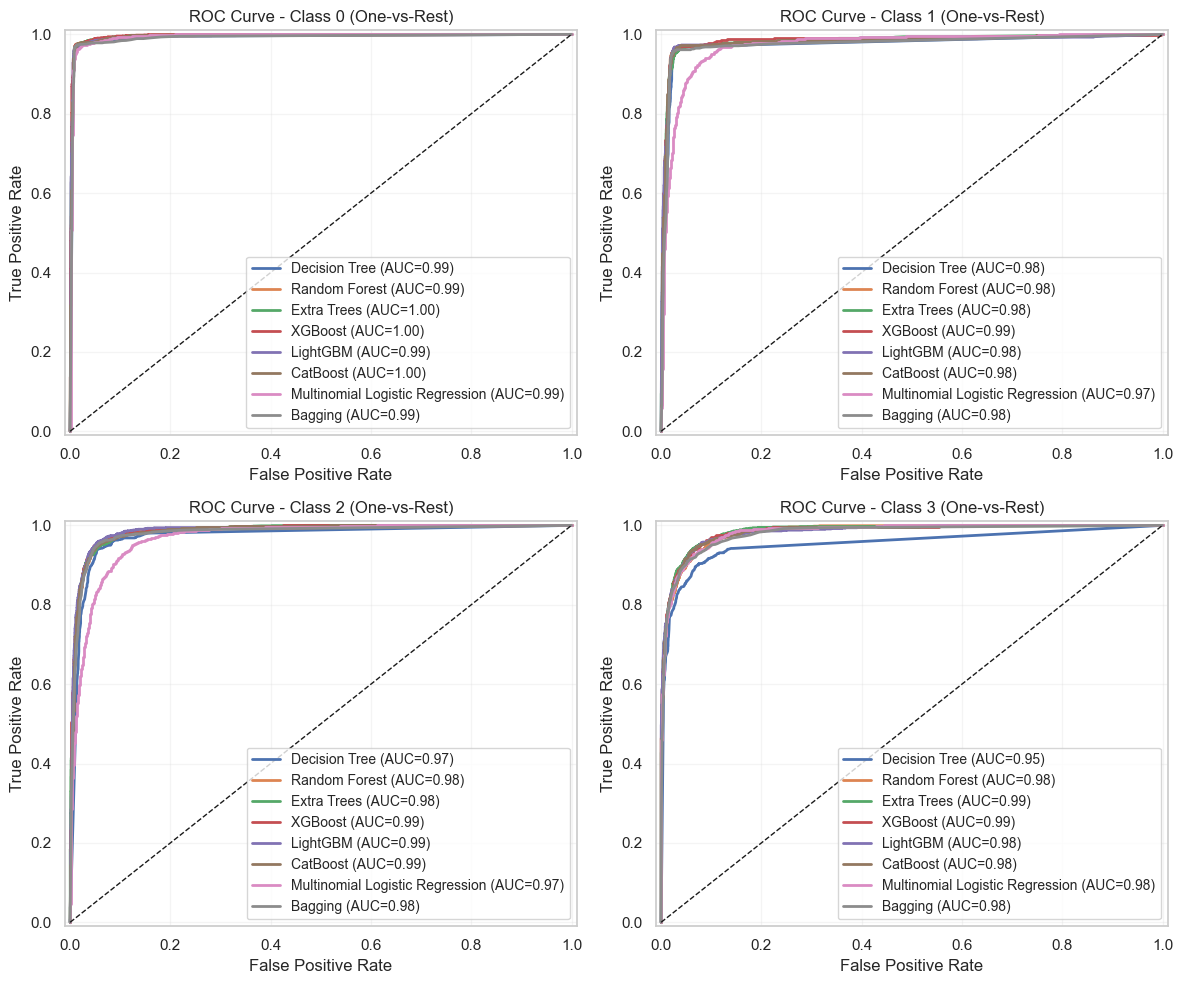

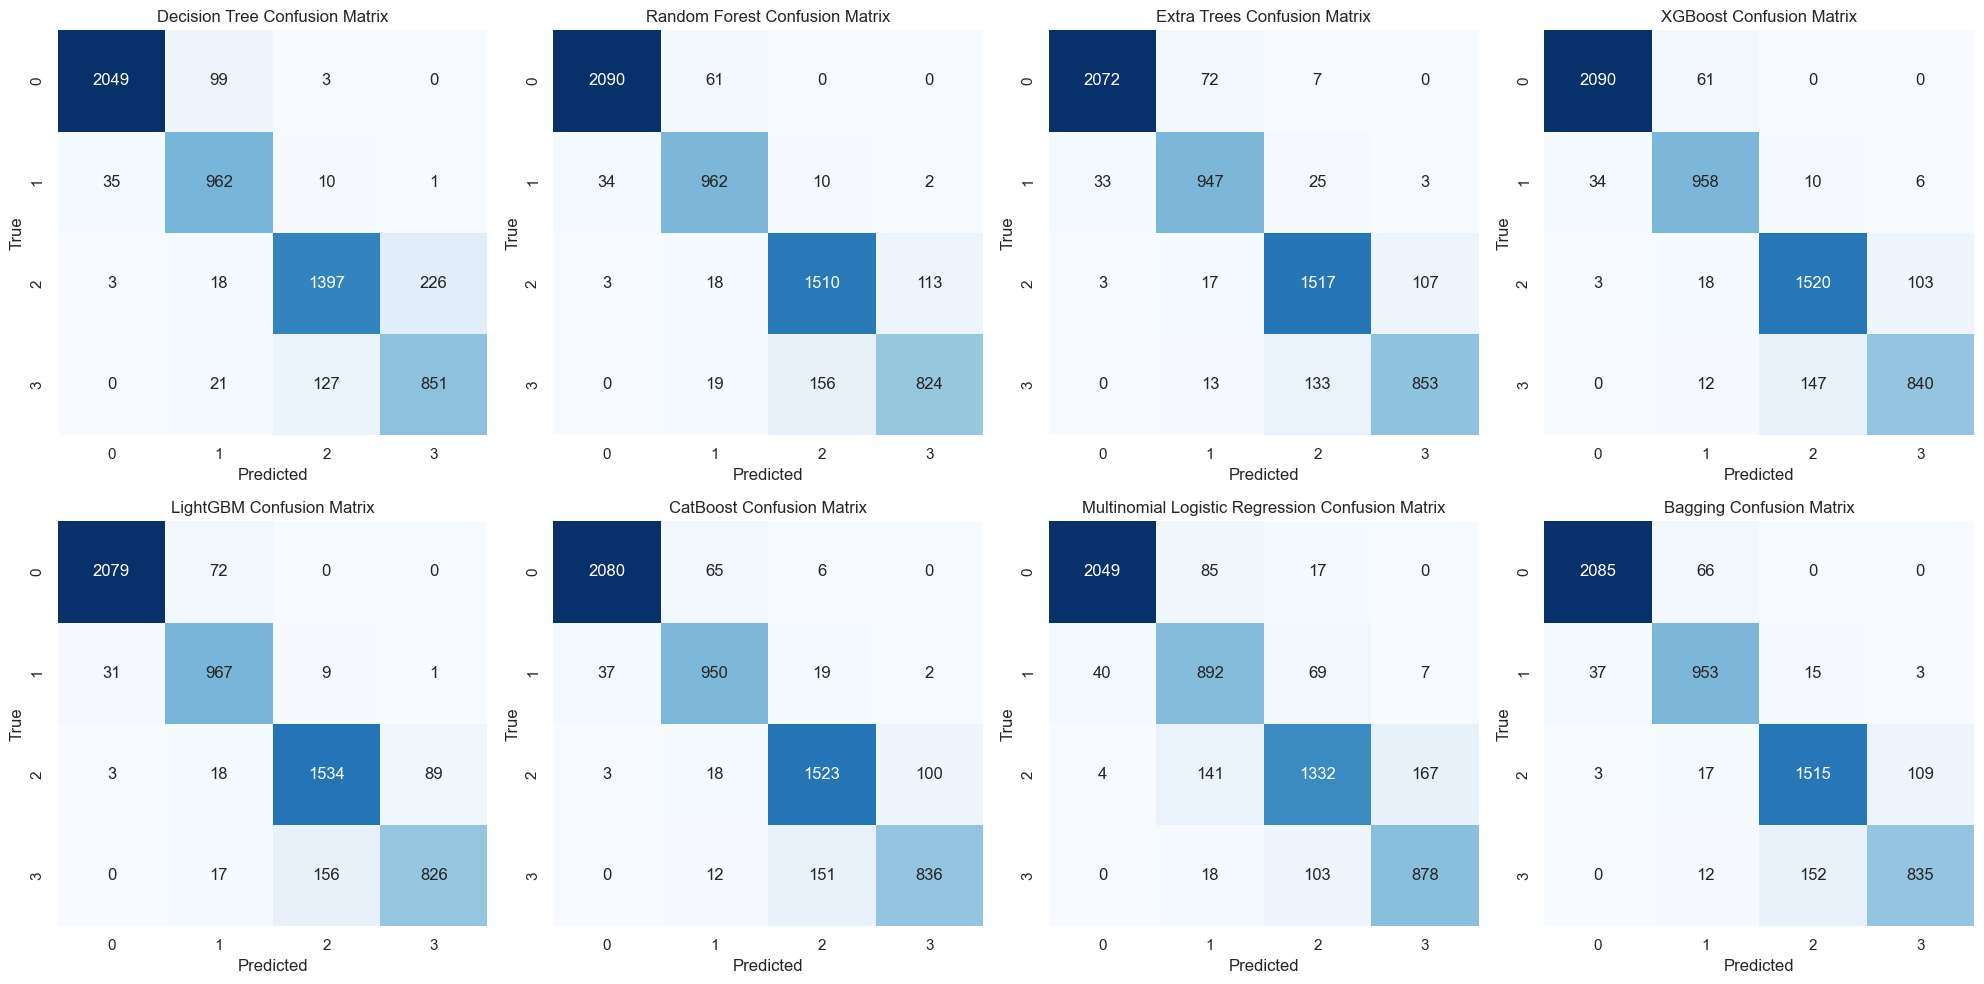

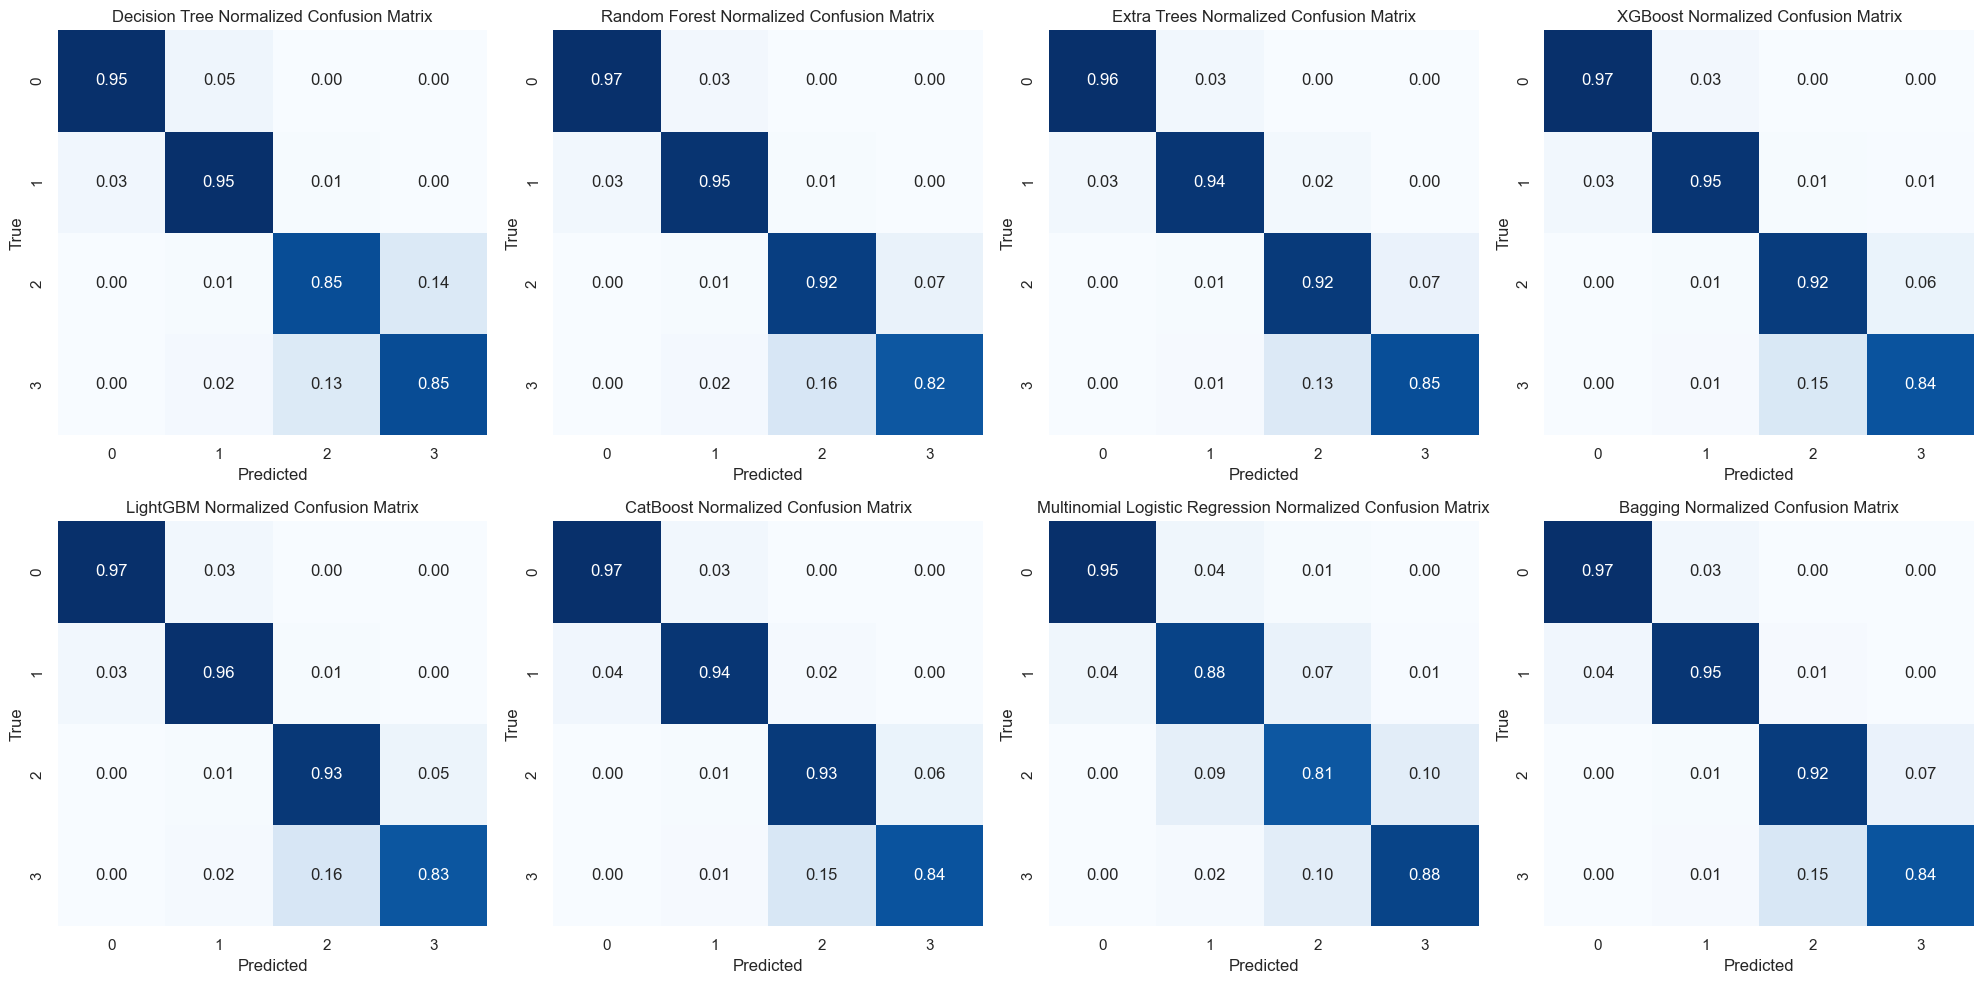

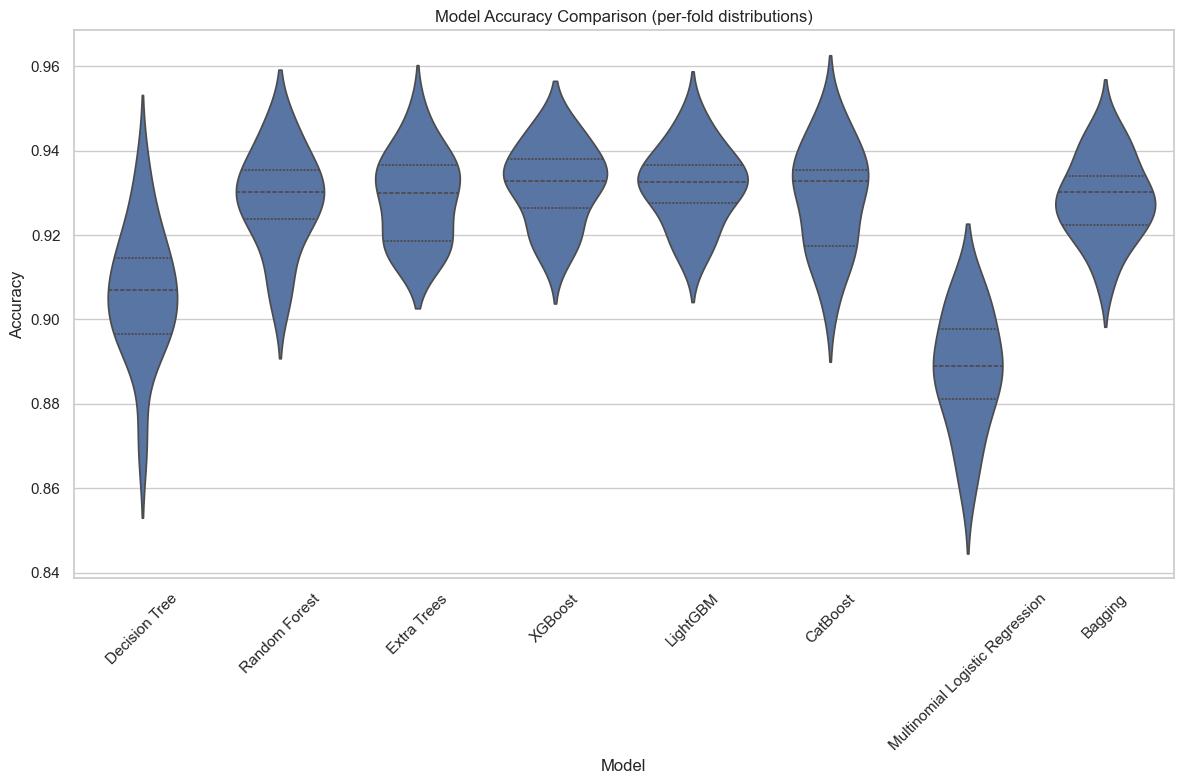

In [9]:
result_df_1, per_class_df_1 = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models/1")

### Hybrid Sampling

Training & Evaluating: Decision Tree
Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: CatBoost
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: Bagging


,Model,Accuracy,Balanced Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),F1 Score (macro),ROC AUC (macro)
2,Extra Trees,0.932000,0.932000,0.932356,0.932000,0.932134,0.932134,0.990113
3,XGBoost,0.934500,0.934500,0.934705,0.934500,0.934583,0.934583,0.990086
5,CatBoost,0.929333,0.929333,0.929836,0.929333,0.929460,0.929460,0.989525
1,Random Forest,0.931333,0.931333,0.931568,0.931333,0.931392,0.931392,0.986866
4,LightGBM,0.929167,0.929167,0.929472,0.929167,0.929234,0.929234,0.986659
7,Bagging,0.922833,0.922833,0.923111,0.922833,0.922943,0.922943,0.983961
6,Multinomial Logistic Regression,0.887667,0.887667,0.887594,0.887667,0.887546,0.887546,0.979931
0,Decision Tree,0.918833,0.918833,0.918886,0.918833,0.918848,0.918848,0.978173


,Model,Class,Precision,Recall,F1 Score,Support
0,Decision Tree,0,0.969169,0.964000,0.966578,1500.0
1,Decision Tree,1,0.939615,0.944000,0.941802,1500.0
2,Decision Tree,2,0.884331,0.876667,0.880482,1500.0
3,Decision Tree,3,0.882431,0.890667,0.886530,1500.0
4,Random Forest,0,0.976918,0.959333,0.968046,1500.0
5,Random Forest,1,0.939096,0.956000,0.947473,1500.0
6,Random Forest,2,0.895395,0.907333,0.901325,1500.0
7,Random Forest,3,0.914865,0.902667,0.908725,1500.0
8,Extra Trees,0,0.978172,0.956000,0.966959,1500.0
9,Extra Trees,1,0.940555,0.949333,0.944924,1500.0


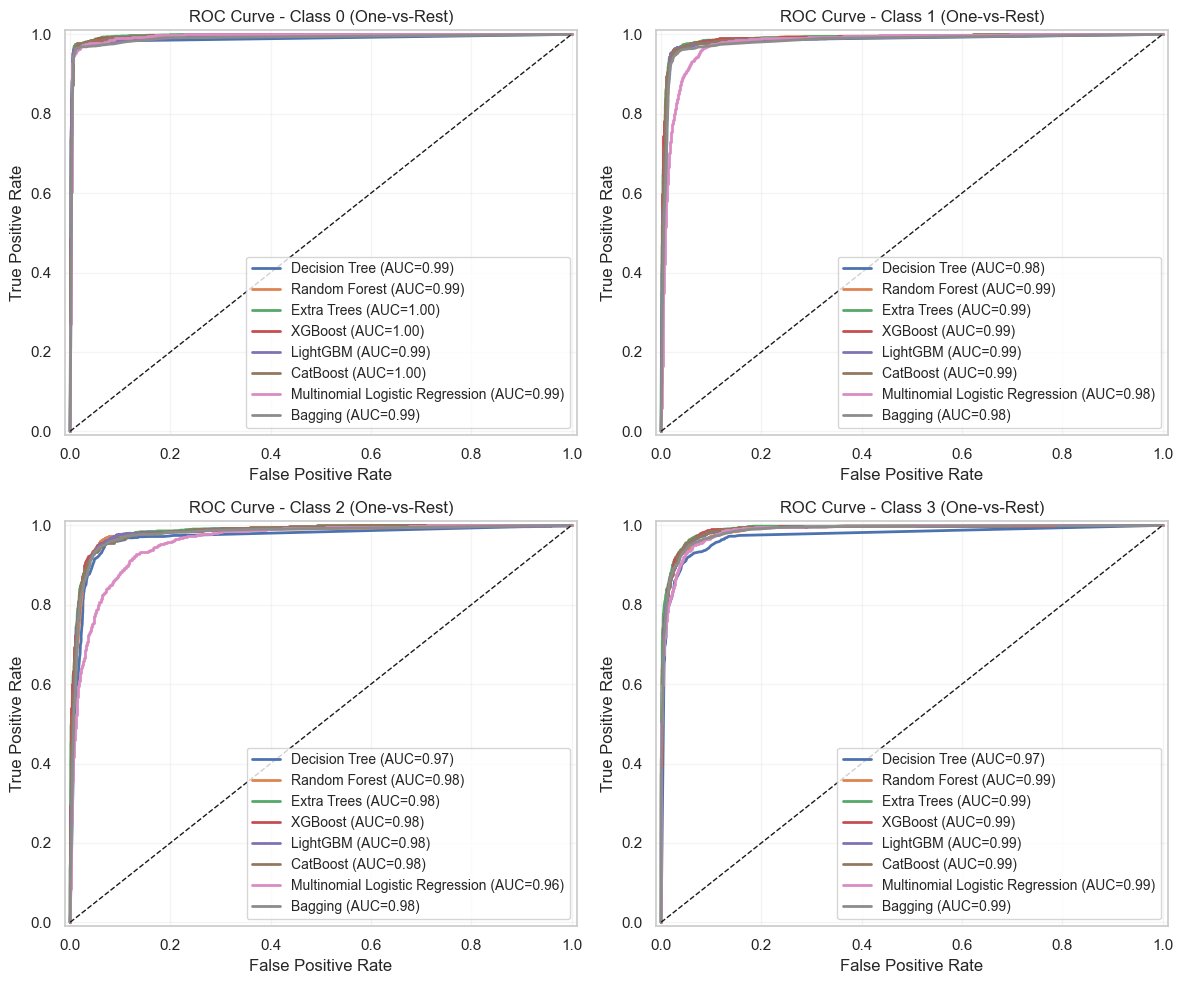

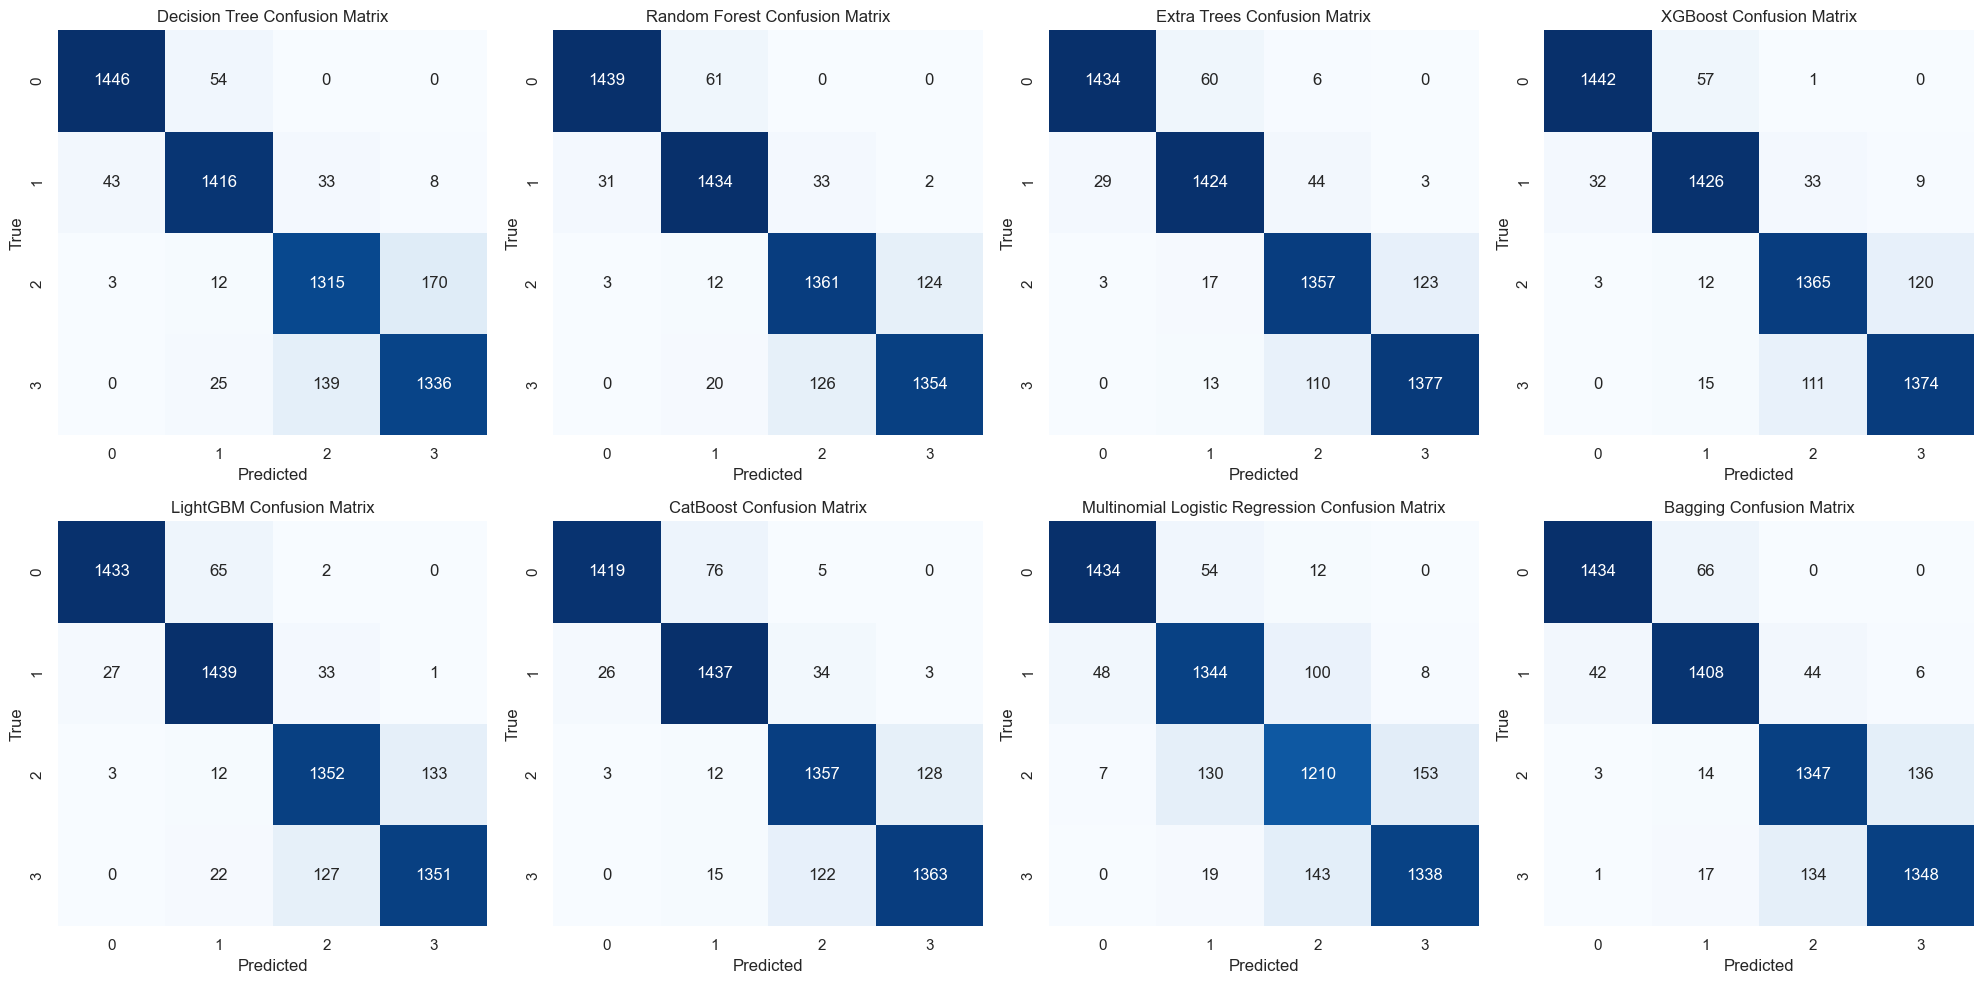

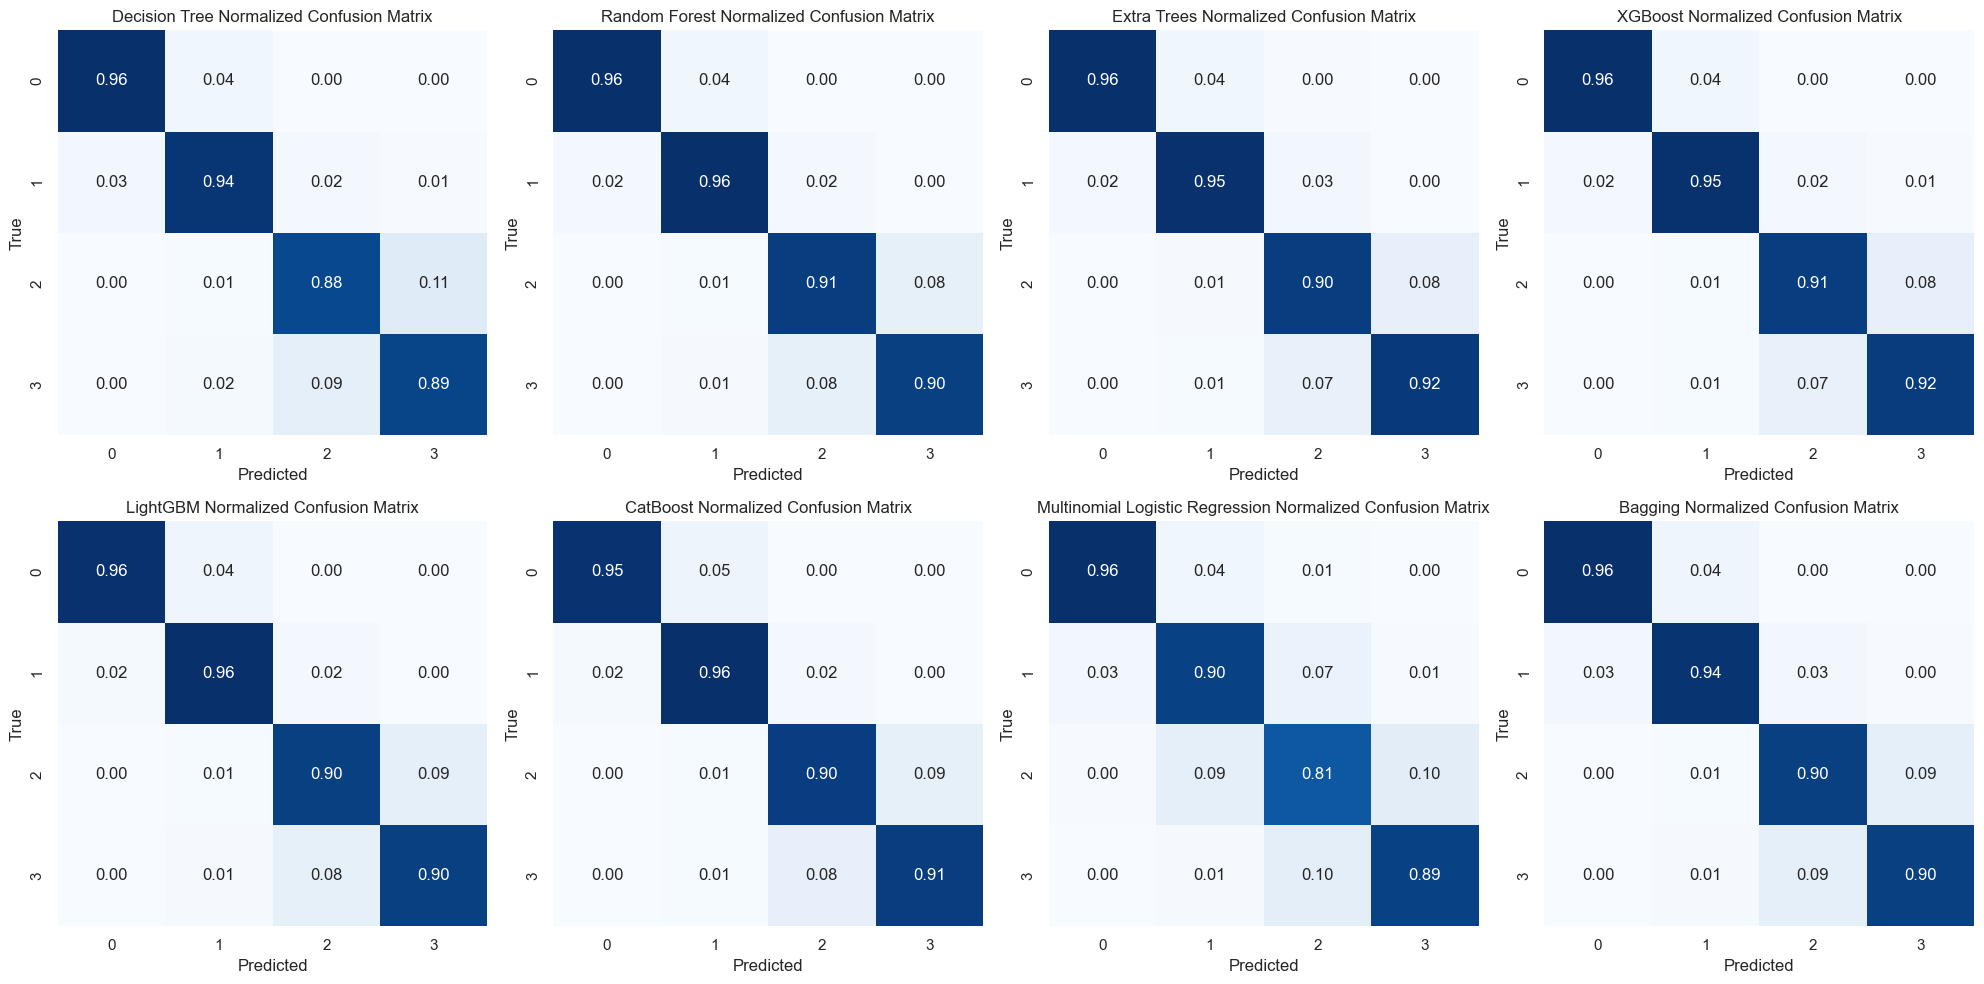

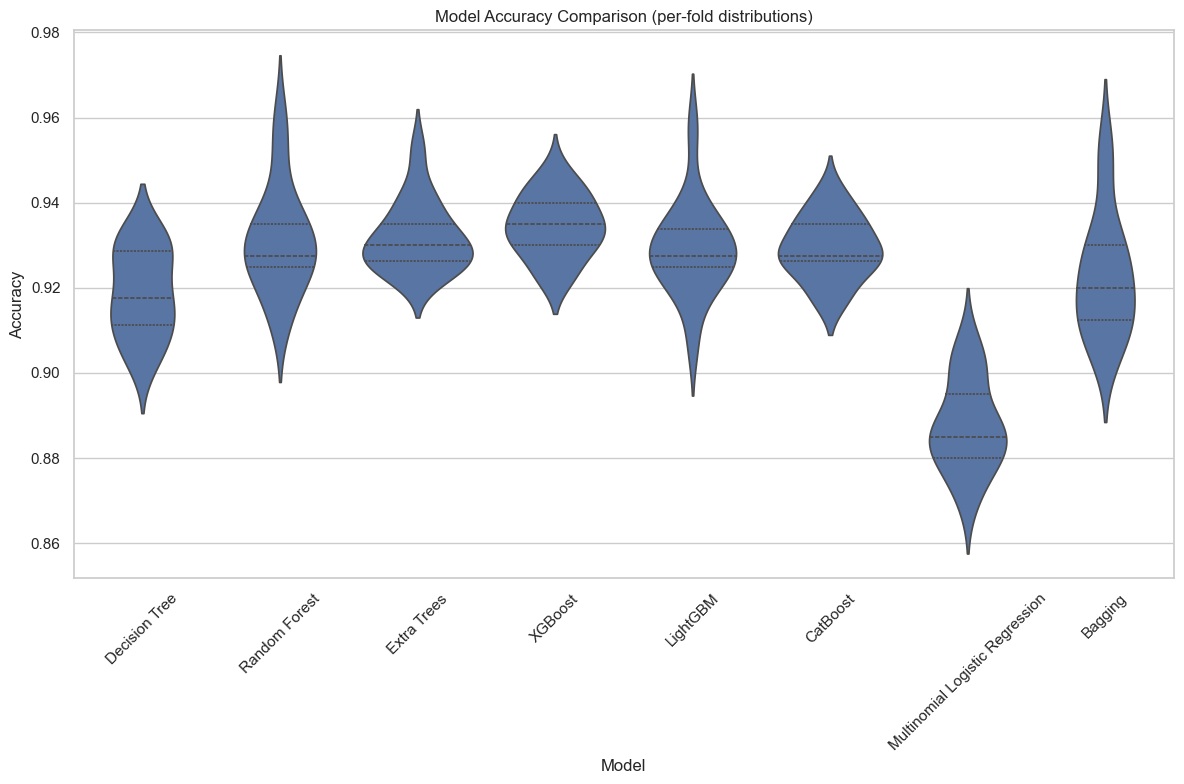

In [10]:
result_df_2, per_class_df_2 = classifier.fit_evaluate_store_models(X_res, y_res, output_dir="../results/all_models/1")

### Save Trees and Rules of Decision Tree

In [11]:
save_xai_models(X_train=X_train, y_train=y_train, models_dir="../results/all_models/1")

Found 2 Decision_Tree models: ['Decision_Tree0', 'Decision_Tree1']
Processing Decision_Tree0
Processing Decision_Tree1
XAI outputs saved.


## Dataset without `CDRSB`, `LDELTOTAL`, and `mPACCdigit` with Classification

In [12]:
X_train.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)
X_res.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)
classifier = ADNIClassifier(classifier="Standard2")

### No Sampling

Training & Evaluating: Decision Tree
Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: CatBoost
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: Bagging


,Model,Accuracy,Balanced Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),F1 Score (macro),ROC AUC (macro)
5,CatBoost,0.736298,0.696559,0.724812,0.736298,0.726359,0.701270,0.917496
3,XGBoost,0.736125,0.700436,0.725077,0.736125,0.728228,0.702839,0.916527
4,LightGBM,0.729404,0.693450,0.719801,0.729404,0.722391,0.697414,0.914893
2,Extra Trees,0.727508,0.708224,0.724540,0.727508,0.724912,0.704171,0.909667
7,Bagging,0.732161,0.692635,0.721740,0.732161,0.723147,0.697945,0.908986
1,Random Forest,0.721303,0.700923,0.718379,0.721303,0.718926,0.697866,0.907818
6,Multinomial Logistic Regression,0.715098,0.703750,0.719948,0.715098,0.714918,0.696083,0.905889
0,Decision Tree,0.662875,0.660548,0.688757,0.662875,0.669221,0.651898,0.857166


,Model,Class,Precision,Recall,F1 Score,Support
0,Decision Tree,0,0.798427,0.754998,0.776105,2151.0
1,Decision Tree,1,0.366941,0.530754,0.433901,1008.0
2,Decision Tree,2,0.688365,0.514599,0.588931,1644.0
3,Decision Tree,3,0.777983,0.841842,0.808654,999.0
4,Random Forest,0,0.808050,0.849372,0.828196,2151.0
5,Random Forest,1,0.471457,0.475198,0.473320,1008.0
6,Random Forest,2,0.697342,0.622263,0.657666,1644.0
7,Random Forest,3,0.809074,0.856857,0.832280,999.0
8,Extra Trees,0,0.811780,0.852162,0.831481,2151.0
9,Extra Trees,1,0.481737,0.484127,0.482929,1008.0


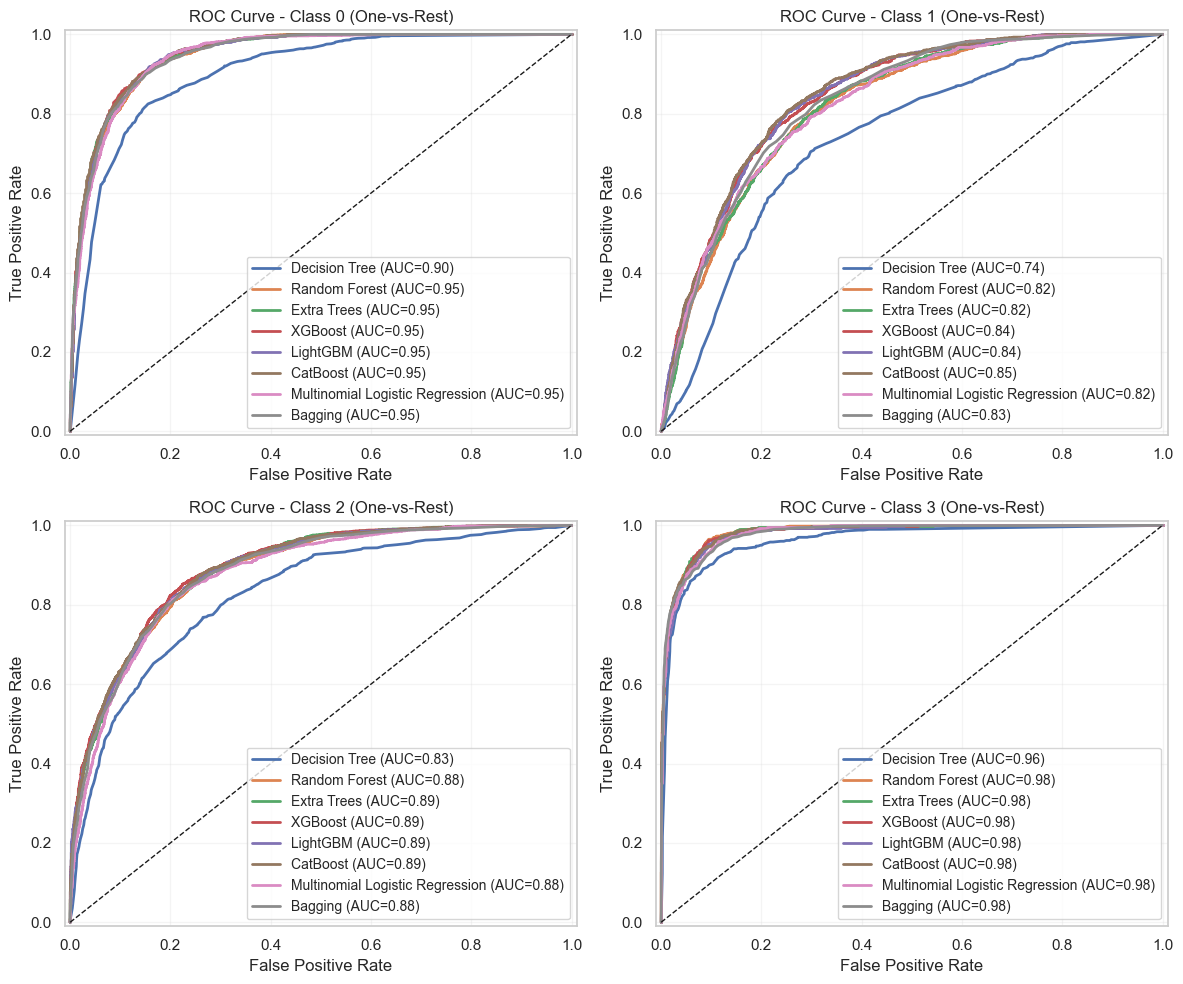

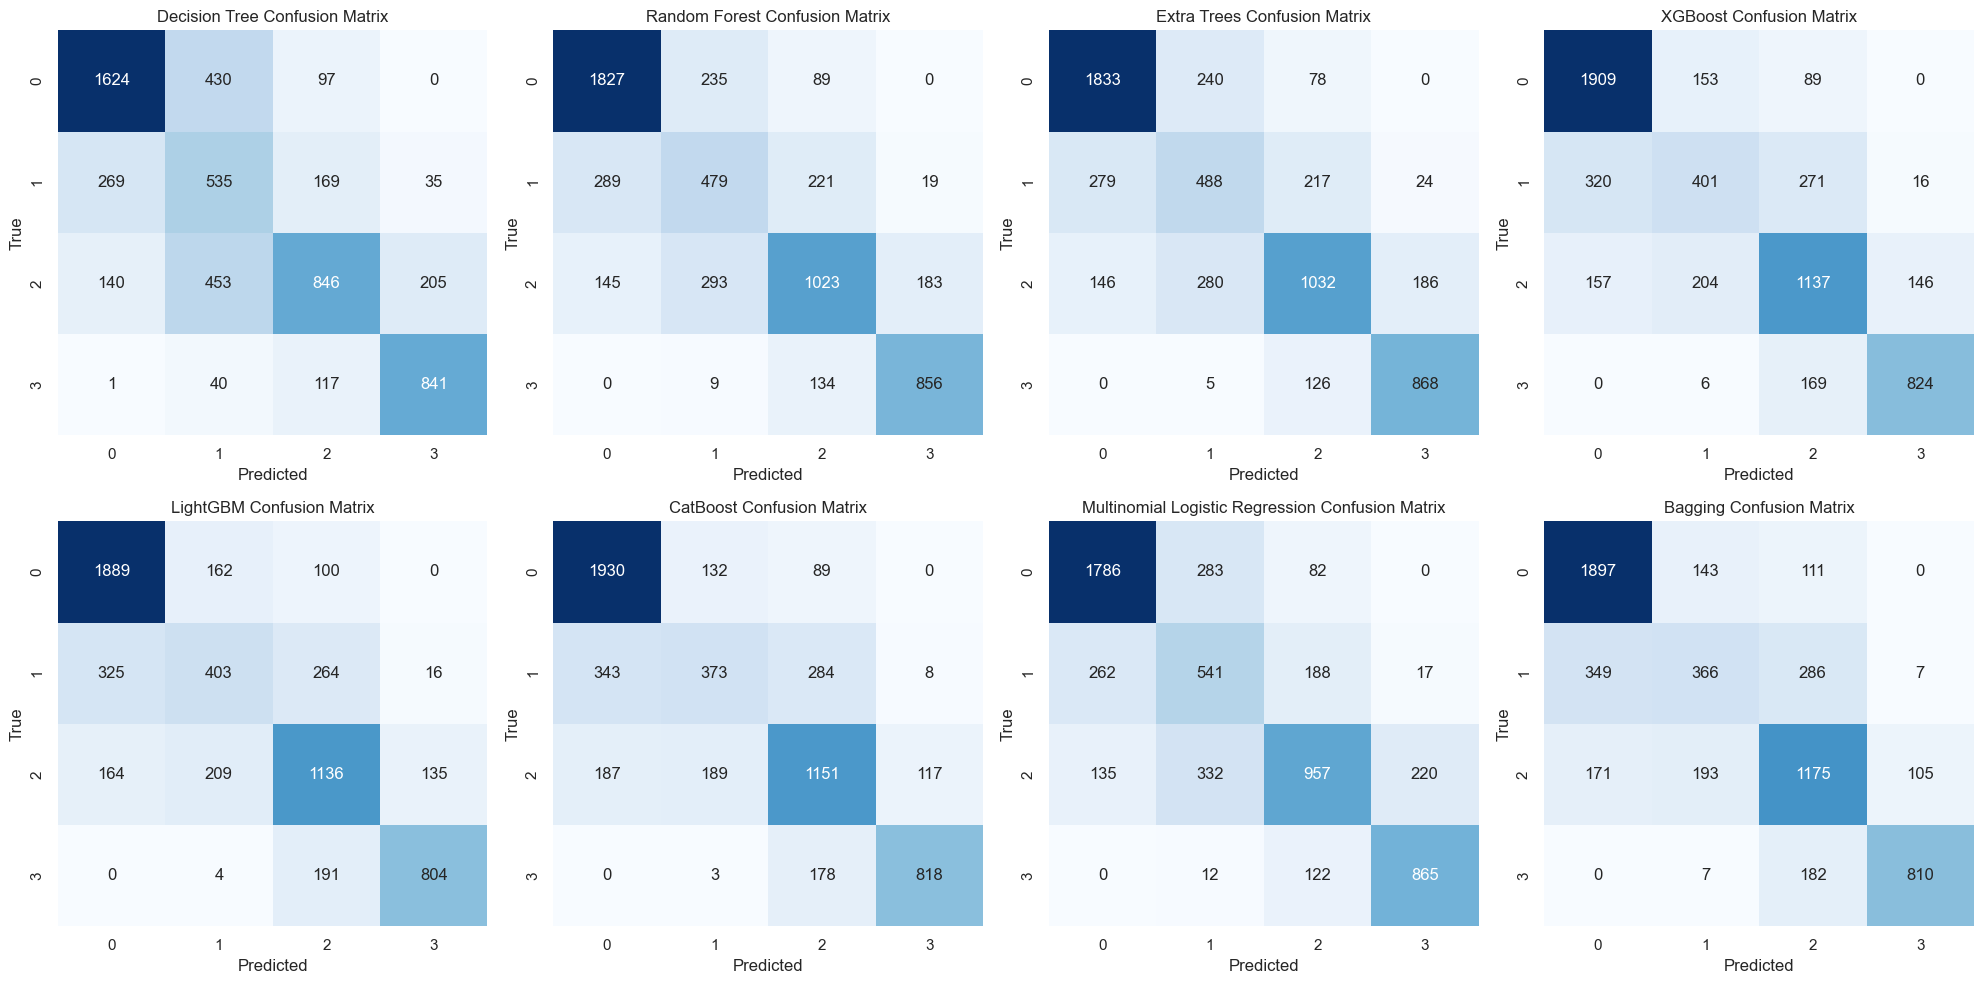

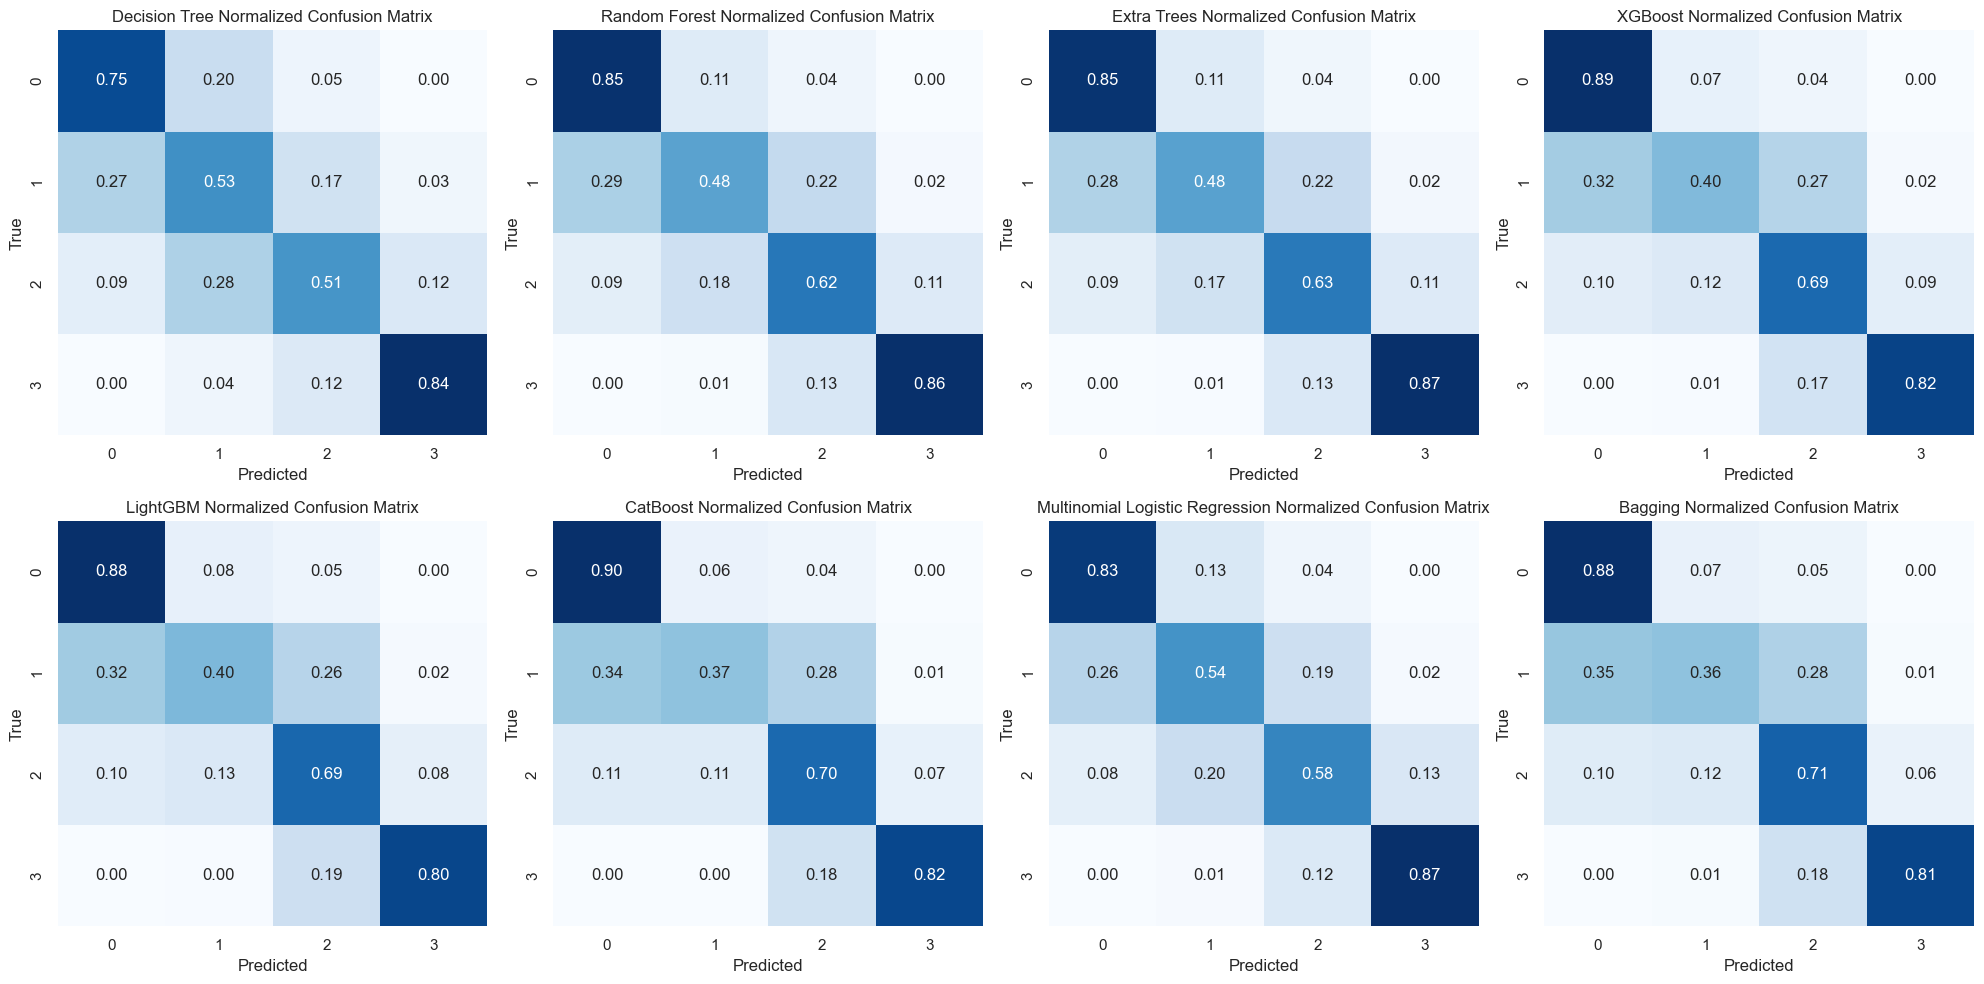

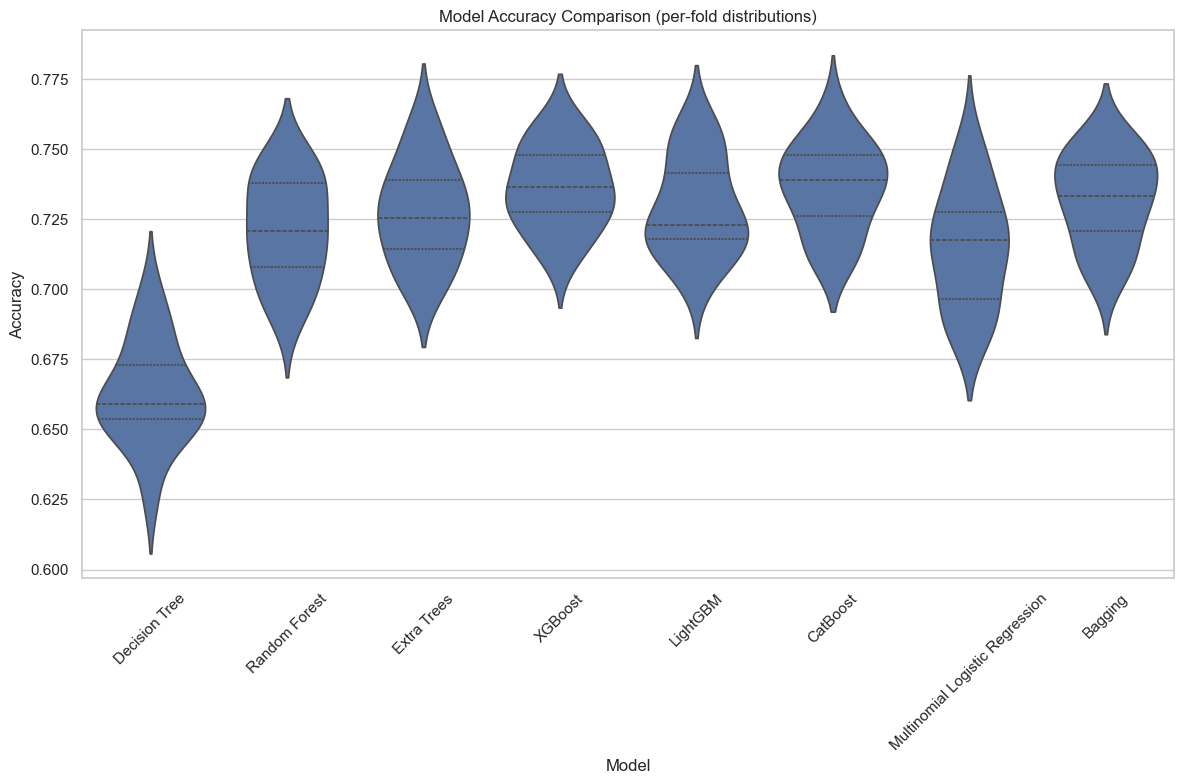

In [13]:
result_df_3, per_class_df_3 = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models/2")

### Hybrid Sampling

Training & Evaluating: Decision Tree
Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: XGBoost
Training & Evaluating: LightGBM
Training & Evaluating: CatBoost
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: Bagging


,Model,Accuracy,Balanced Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),F1 Score (macro),ROC AUC (macro)
3,XGBoost,0.761500,0.761500,0.759625,0.761500,0.759870,0.759870,0.934559
4,LightGBM,0.762667,0.762667,0.761621,0.762667,0.761433,0.761433,0.932801
5,CatBoost,0.751000,0.751000,0.748344,0.751000,0.748796,0.748796,0.931449
7,Bagging,0.755333,0.755333,0.754702,0.755333,0.754220,0.754220,0.930974
2,Extra Trees,0.742500,0.742500,0.738144,0.742500,0.738971,0.738971,0.926380
1,Random Forest,0.736000,0.736000,0.731957,0.736000,0.732424,0.732424,0.921170
6,Multinomial Logistic Regression,0.723000,0.723000,0.719413,0.723000,0.720185,0.720185,0.915425
0,Decision Tree,0.682167,0.682167,0.676738,0.682167,0.677998,0.677998,0.872154


,Model,Class,Precision,Recall,F1 Score,Support
0,Decision Tree,0,0.698663,0.766667,0.731087,1500.0
1,Decision Tree,1,0.554355,0.547333,0.550822,1500.0
2,Decision Tree,2,0.618083,0.528667,0.569889,1500.0
3,Decision Tree,3,0.835849,0.886000,0.860194,1500.0
4,Random Forest,0,0.740322,0.828667,0.782007,1500.0
5,Random Forest,1,0.642170,0.623333,0.632612,1500.0
6,Random Forest,2,0.680246,0.590000,0.631917,1500.0
7,Random Forest,3,0.865090,0.902000,0.883159,1500.0
8,Extra Trees,0,0.751182,0.847333,0.796366,1500.0
9,Extra Trees,1,0.654232,0.608000,0.630270,1500.0


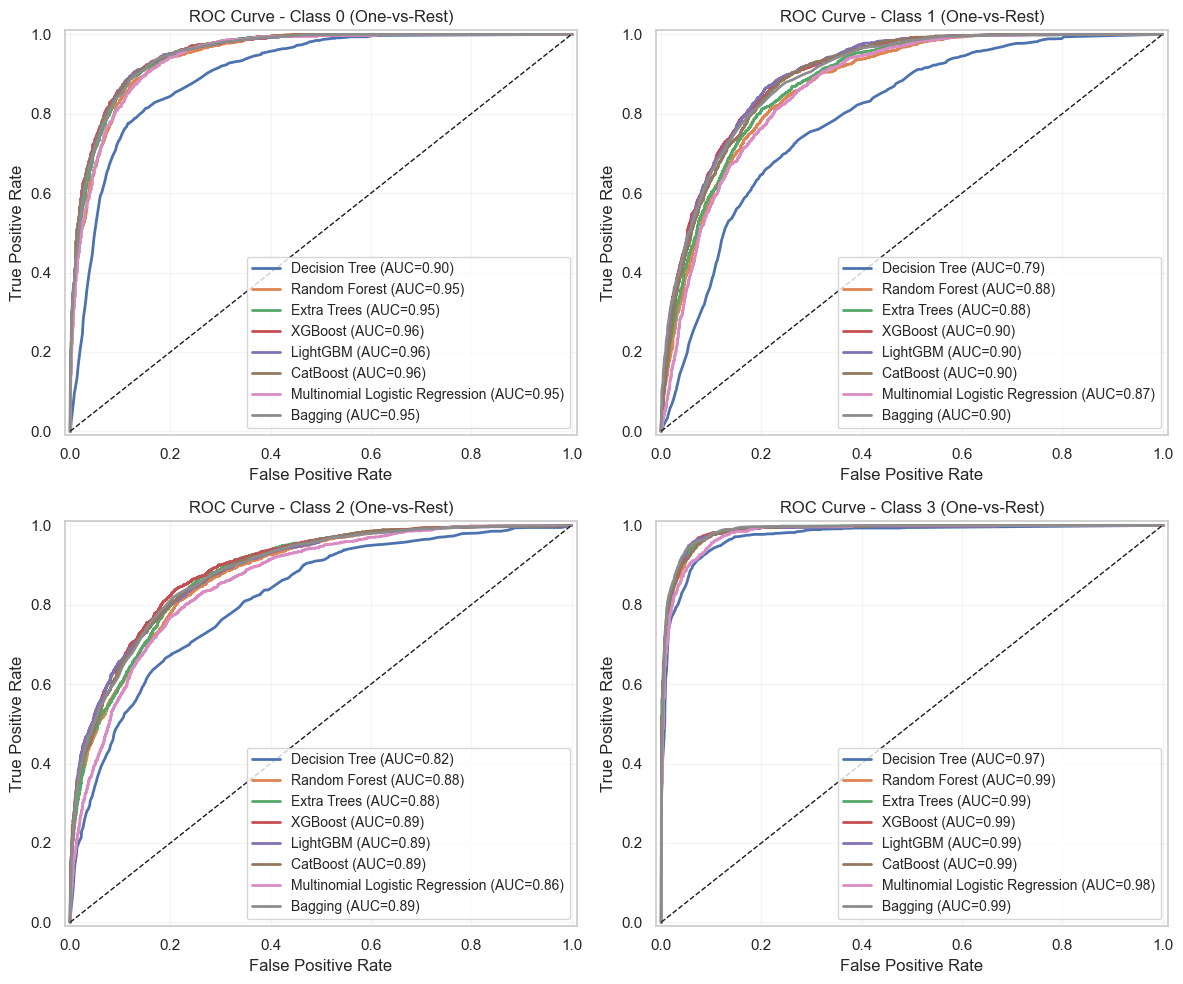

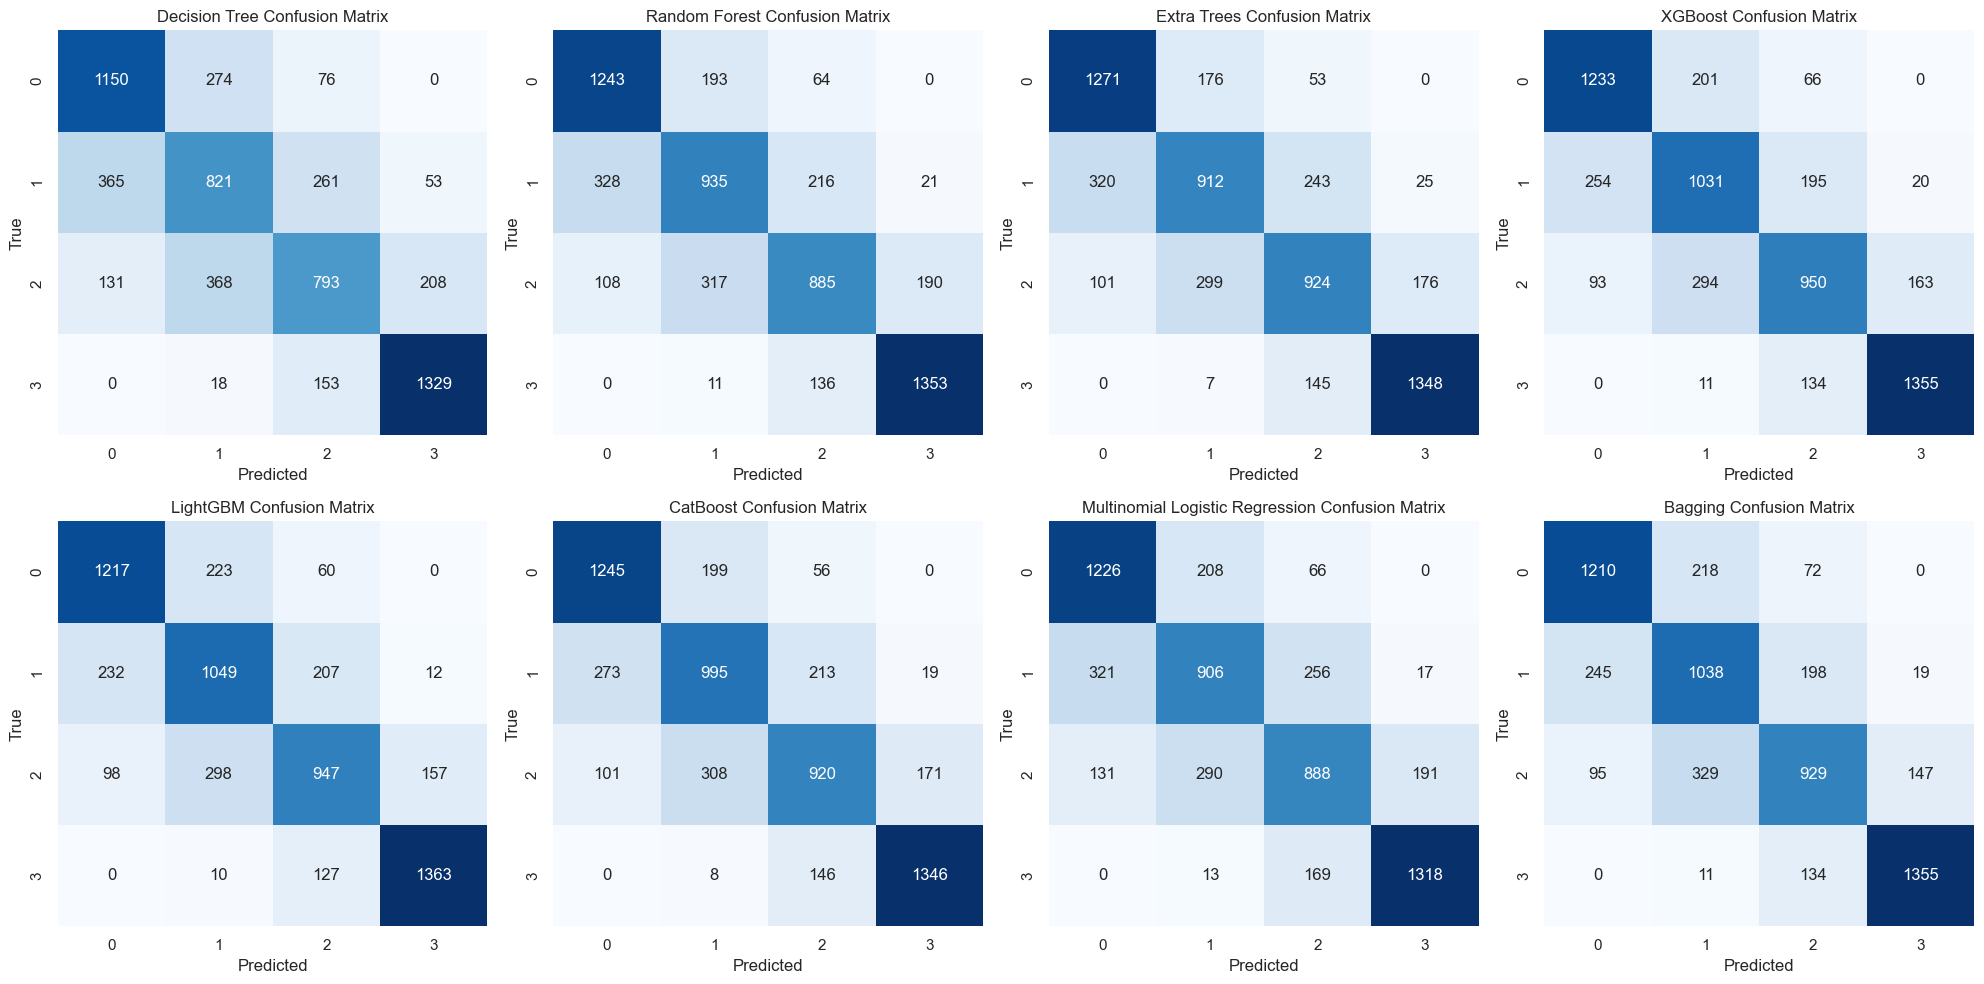

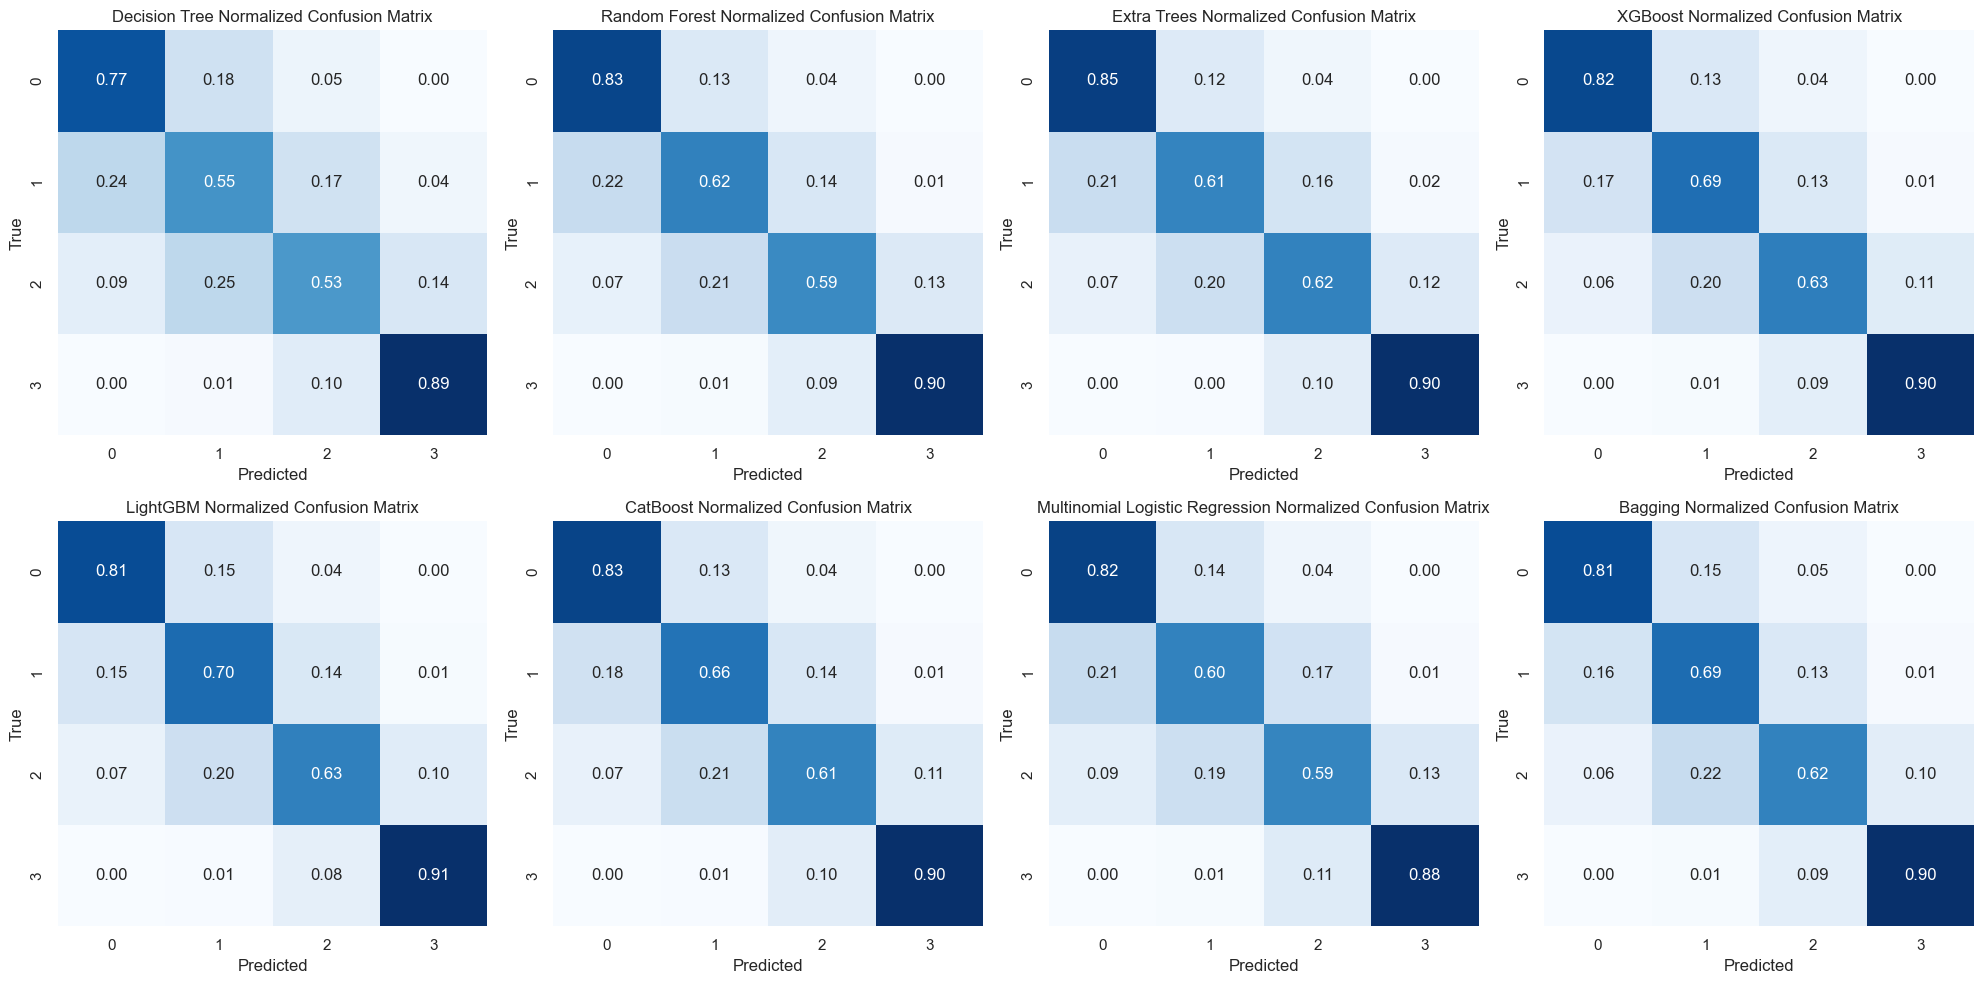

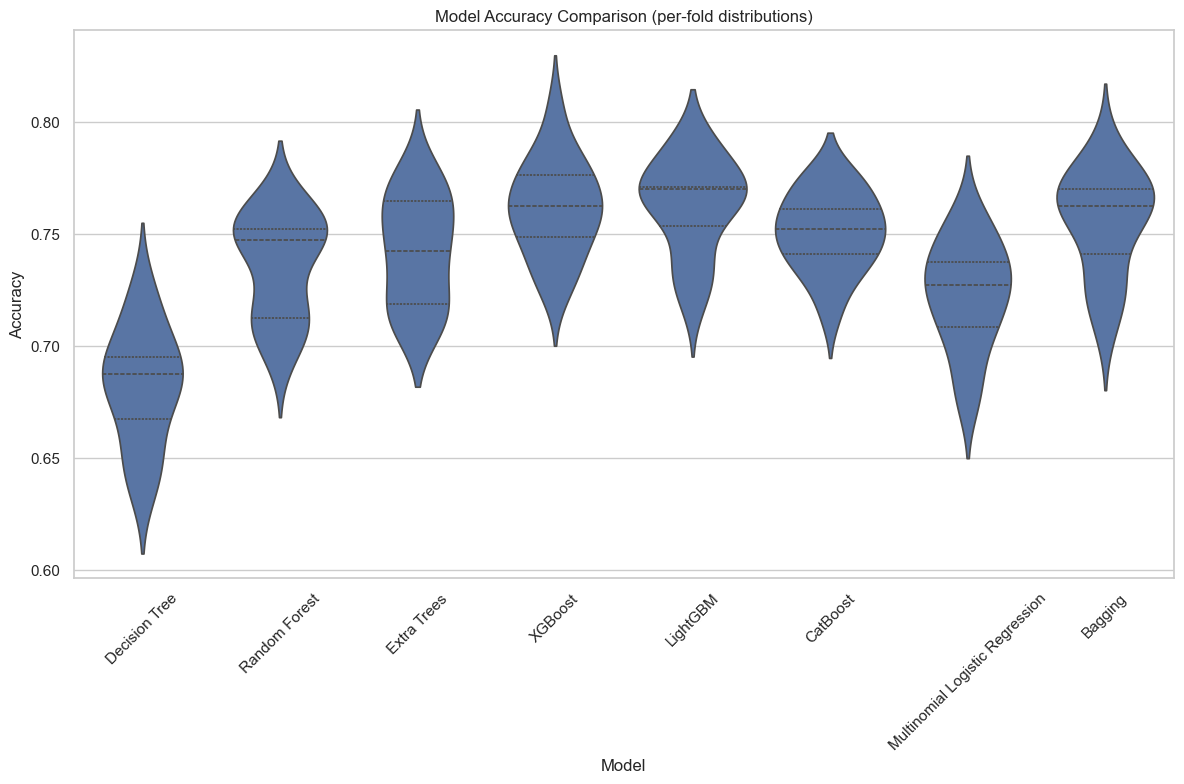

In [14]:
result_df_4, per_class_df_4 = classifier.fit_evaluate_store_models(X_res, y_res, output_dir="../results/all_models/2")

### Save Trees and Rules of Decision Tree

In [15]:
save_xai_models(X_train=X_train, y_train=y_train, models_dir="../results/all_models/2")

Found 2 Decision_Tree models: ['Decision_Tree0', 'Decision_Tree1']
Processing Decision_Tree0
Processing Decision_Tree1
XAI outputs saved.
